In [686]:
import mne
import sklearn.decomposition
from matplotlib import pyplot as plt
import pickle
import numpy as np
import pandas as pd
from scipy.fft import fftfreq
from scipy import fft
import sklearn
from scipy.stats import entropy, spearmanr

In [687]:
run = 'run2'
sid = 'S5'

In [688]:
def read_file(filename):
    with open(filename, 'rb') as file:
        raw = pickle.load(file)
    return raw

In [689]:
def get_event_data(data, events, event_id, event_count = 0, event_length = 3.0):
    event = events[events['Event'] == event_id].iloc[event_count]
    event_sub = (event['EventEnd'] - event['EventStart'] - event_length) / 2
    return data.copy().crop(tmin = event['EventStart'] + event_sub, tmax = event['EventEnd'] - event_sub)


def get_event_data_by_event(data, event, event_length = 3.0):
    event_sub = (event['EventEnd'] - event['EventStart'] - event_length) / 2
    return data.copy().crop(tmin = event['EventStart'] + event_sub, tmax = event['EventEnd'] - event_sub)

Effective window size : 3.413 (s)


/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


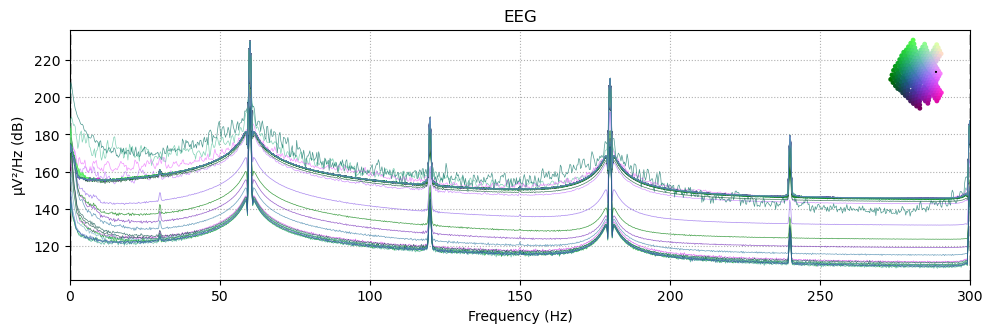

In [690]:
raw = read_file(f'output/problem-at-hand/{sid}/{run}/mne_raw.pkl')

raw.compute_psd().plot()
plt.show()

Effective window size : 3.413 (s)


/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


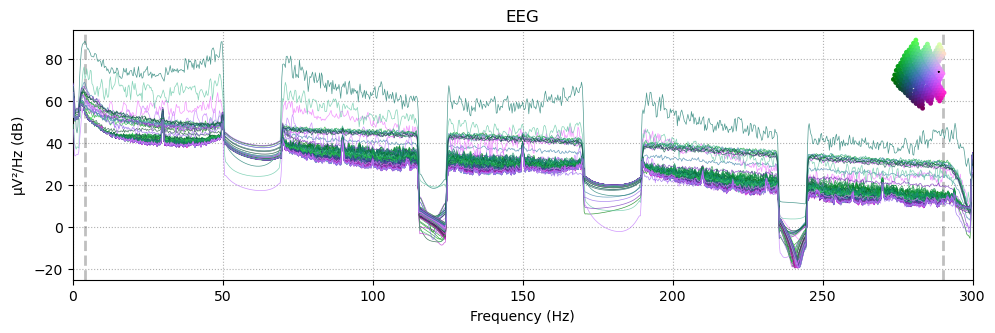

In [691]:
raw = read_file(f'output/problem-at-hand/{sid}/{run}/mne_filtered.pkl')

raw.compute_psd().plot()
plt.show()

Effective window size : 3.413 (s)


/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


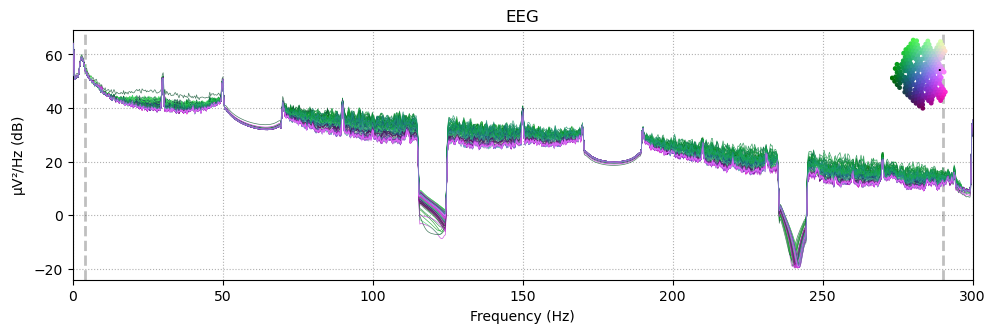

In [692]:
final = read_file(f'output/problem-at-hand/{sid}/{run}/mne_good_channels.pkl')
events = read_file(f'output/problem-at-hand/{sid}/{run}/events.pkl')
events = events.drop(index = [0, 1]).reset_index(drop = True)
events['Event'] = events['Event'].astype('category', copy = False)
events['EventID'] = [f'Event{x}' for x in range(0, len(events))]

final.compute_psd().plot()
plt.show()

Fitting ICA to data using 238 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 5.6s.


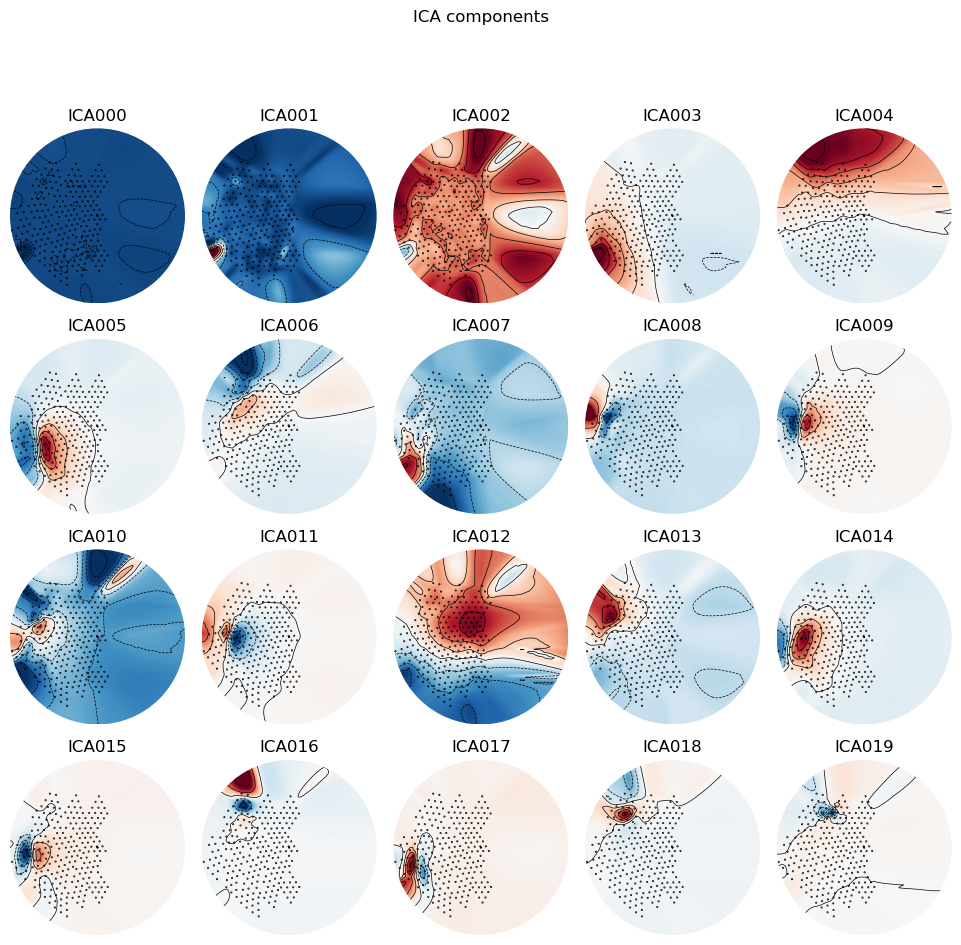

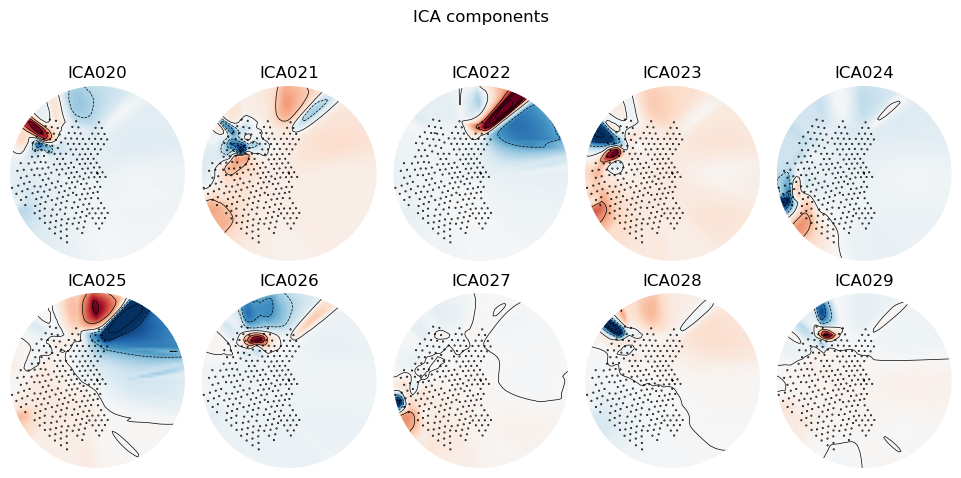

In [693]:
ica = mne.preprocessing.ICA(n_components = 30, random_state = 42, max_iter = 2000)
ica.fit(final)
ica.plot_components()
plt.show()

Fitting ICA to data using 238 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


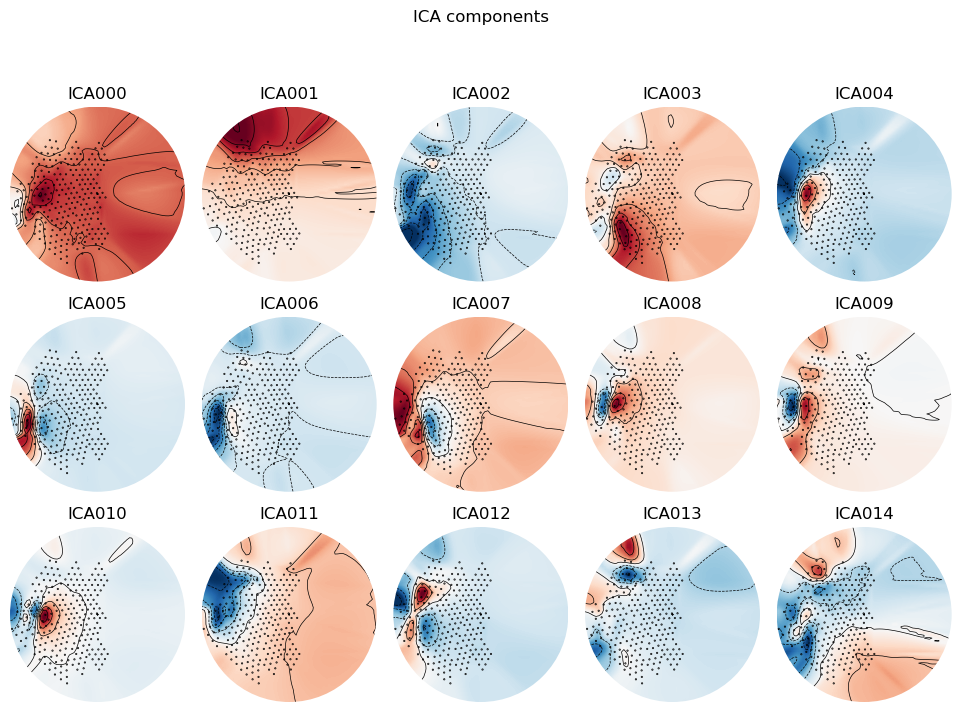

In [694]:
finger = get_event_data(final, events, event_id = 2)
ica = mne.preprocessing.ICA(n_components = 15, random_state = 42, max_iter = 2000)
ica.fit(finger)
ica.plot_components()
plt.show()

In [695]:
batch_size = 16
total_electrodes = 256

unique_batches = [x for x in range(0, int(total_electrodes / batch_size))]
batches = pd.DataFrame({
    'Channel': [f'X{x}' for x in range(0, total_electrodes)],
    'Batch': np.repeat(unique_batches, batch_size)
})
batches = batches[np.isin(batches['Channel'], final.ch_names)]

assert len(batches) == len(final.ch_names)

In [696]:
# Idea: 
# subset the data into events
# take one event
# divide electrodes into batches
# in each batch, extract the features

# Short note on feature selection
# The mu, beta, and gamma powerbands were selected because
# they were shown to be related to motor function.
# The extracted features are just a play on these powerbands.
# These features are quite simple and I will probably
# explore other types of features once I have more time.
# Currently, I was more focused on removing bad channels and
# cleaning the data properly.

# Also, this is currently focusing on a single file. Again,
# due to the lack of time :)

In [697]:
def get_band_power_mean(data, channels, fmin, fmax):
    return np.mean(data.compute_psd(picks = channels, fmin = fmin, fmax = fmax, verbose = False).get_data())

In [698]:
def get_power_entropy(epoch, sample_rate, range_hz):
    freq = fft.rfftfreq(len(epoch), 1 / sample_rate)
    spectrum = np.abs(fft.rfft(epoch))
    min_freq = np.argwhere(freq >= range_hz[0])[0][0]
    max_freq = np.argwhere(freq <= range_hz[1])[-1][0]
    spectrum_crop = spectrum[min_freq:max_freq]

    # Normalize the power spectrum
    normalized_spectrum = spectrum_crop / np.sum(spectrum_crop)

    # Calculate power spectral entropy
    power_entropy = entropy(normalized_spectrum, base = 2)

    return np.mean(power_entropy)

In [699]:
def standard_deviation_in_bandwidth(signal, sample_rate, bandwidth):
    # Perform FFT to get the frequency components
    frequencies = fftfreq(len(signal), d = 1 / sample_rate)
    amplitudes = np.abs(fft.fft(signal))

    # Identify frequency bins within the desired bandwidth
    mask = (frequencies >= bandwidth[0]) & (frequencies <= bandwidth[1])

    # Extract amplitudes within the specified bandwidth
    amplitudes_in_bandwidth = amplitudes[mask]

    # Calculate the standard deviation of the amplitudes
    std_deviation = np.std(amplitudes_in_bandwidth)

    return std_deviation

In [700]:
features = []
sfreq = final.info['sfreq']

for index, event in events.iterrows():
    # Get data from each individual event
    finger = get_event_data_by_event(final, event)

    # Loop through electrode batches and extract band features
    for batch in unique_batches:
        channels = list(batches[batches['Batch'] == batch]['Channel'])

        average_mu = get_band_power_mean(finger, channels, 8, 13)
        average_beta = get_band_power_mean(finger, channels, 13, 30)
        average_gamma = get_band_power_mean(finger, channels, 30, 100)

        entropy_mu = get_power_entropy(finger.get_data(picks = channels).T, sfreq, (8, 13))
        entropy_beta = get_power_entropy(finger.get_data(picks = channels).T, sfreq, (13, 30))
        entropy_gamma = get_power_entropy(finger.get_data(picks = channels).T, sfreq, (30, 100))

        sd_mu = standard_deviation_in_bandwidth(finger.get_data(picks = channels).T, sfreq, (8, 13))
        sd_beta = standard_deviation_in_bandwidth(finger.get_data(picks = channels).T, sfreq, (13, 30))
        sd_gamma = standard_deviation_in_bandwidth(finger.get_data(picks = channels).T, sfreq, (30, 100))

        features.append({
            'Event': event['Event'],
            'EventID': event['EventID'],
            'Batch': batch,

            'feature_mu': average_mu,
            'feature_beta': average_beta,
            'feature_gamma': average_gamma,

            'entropy_mu': entropy_mu,
            'entropy_beta': entropy_beta,
            'entropy_gamma': entropy_gamma,

            'sd_mu': sd_mu,
            'sd_beta': sd_beta,
            'sd_gamma': sd_gamma
        })

In [701]:
features = pd.DataFrame(features)

In [702]:
def z_score(data):
    return (data - np.mean(data)) / np.std(data)

In [703]:
features['mu'] = z_score(np.log(features['feature_mu']))
features['beta'] = z_score(np.log(features['feature_beta']))
features['gamma'] = z_score(np.log(features['feature_gamma']))

features['scaled_entropy_mu'] = z_score(features['entropy_mu'])
features['scaled_entropy_beta'] = z_score(features['entropy_beta'])
features['scaled_entropy_gamma'] = z_score(features['entropy_gamma'])

features['sd_mu'] = z_score(features['sd_mu'])
features['sd_beta'] = z_score(features['sd_beta'])
features['sd_gamma'] = z_score(features['sd_gamma'])

In [704]:
def plot_features_in_batches(feature_table, feature):
    df0 = feature_table[feature_table['Event'] == 0.0]
    plt.scatter(df0['Batch'], df0[feature], color = 'gray', label = 'No movement')

    df2 = feature_table[feature_table['Event'] == 2.0]
    plt.scatter(df2['Batch'] + 1 / 6, df2[feature], color = 'orange', label = 'Finger 1')

    df3 = feature_table[feature_table['Event'] == 3.0]
    plt.scatter(df3['Batch'] + 2 / 6, df3[feature], color = 'violet', label = 'Finger 2')

    df4 = feature_table[feature_table['Event'] == 4.0]
    plt.scatter(df4['Batch'] + 3 / 6, df4[feature], color = 'green', label = 'Finger 3')

    df5 = feature_table[feature_table['Event'] == 5.0]
    plt.scatter(df5['Batch'] + 4 / 6, df5[feature], color = 'red', label = 'Finger 4')

    df6 = feature_table[feature_table['Event'] == 6.0]
    plt.scatter(df6['Batch'] + 5 / 6, df6[feature], color = 'blue', label = 'Finger 5')

    plt.show()

In [705]:
p_sign_level = 0.1

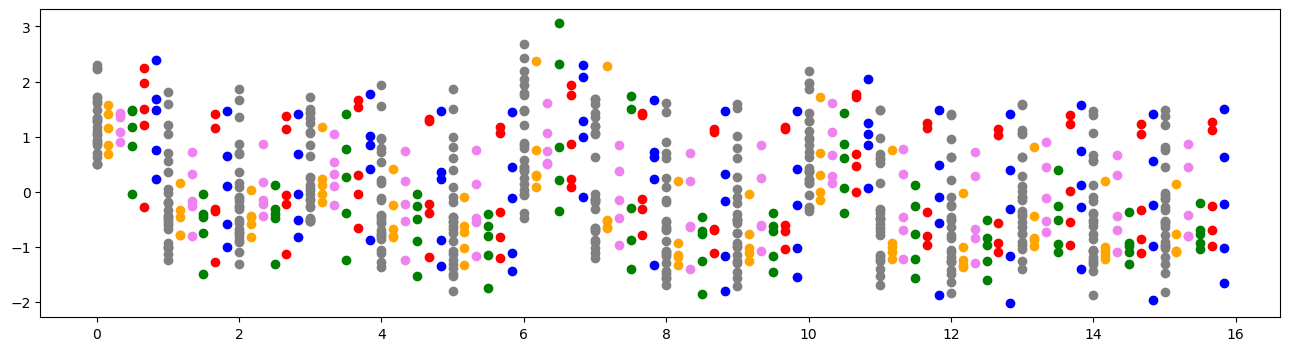

In [706]:
plt.figure(figsize = (16, 4))
plot_features_in_batches(features, 'beta')

In [707]:
# Beta power band is not associated with the outcome in any batch
for batch in unique_batches:
    dt = features[features['Batch'] == batch]
    corr = spearmanr(dt['beta'], dt['Event'])
    if corr[1] < p_sign_level:
        print(batch, corr[0])

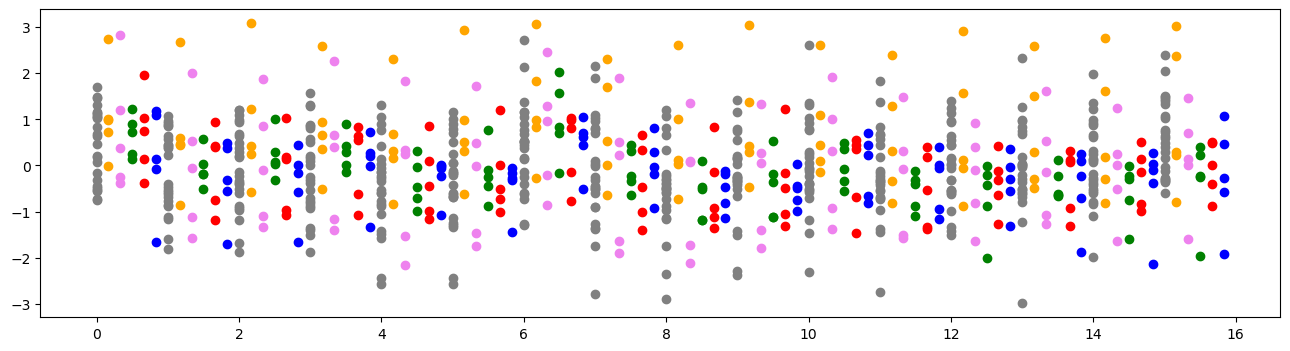

In [708]:
plt.figure(figsize = (16, 4))
plot_features_in_batches(features, 'mu')

In [709]:
# Only the 15th electrode batch has significant correlation with the outcome
for batch in unique_batches:
    dt = features[features['Batch'] == batch]
    corr = spearmanr(dt['mu'], dt['Event'])
    if corr[1] < p_sign_level:
        print('Batch: ', batch)
        print('Correlation: ', corr[0])

Batch:  15
Correlation:  -0.32607320075639656


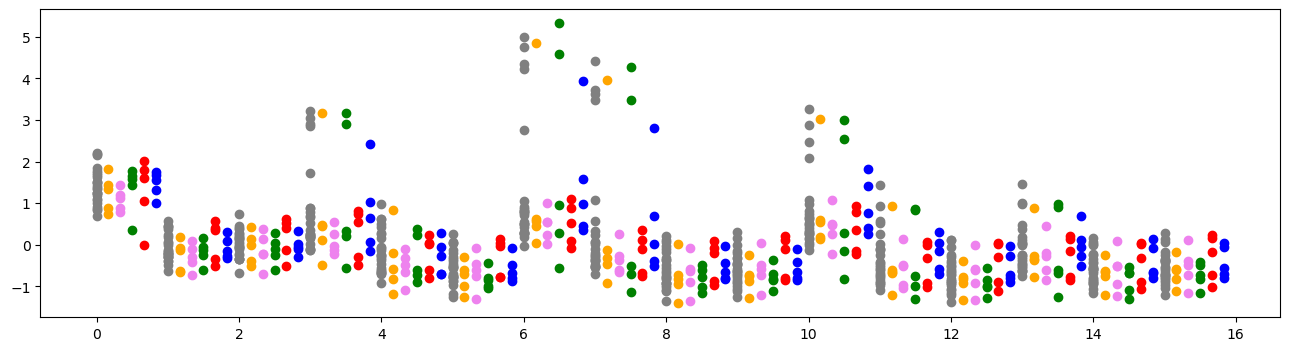

In [710]:
plt.figure(figsize = (16, 4))
plot_features_in_batches(features, 'gamma')

In [711]:
# Gamma power not correlated to outcome in any of the electrodes
for batch in unique_batches:
    dt = features[features['Batch'] == batch]
    corr = spearmanr(dt['gamma'], dt['Event'])
    if corr[1] < p_sign_level:
        print('Batch: ', batch)
        print('Correlation: ', corr[0])

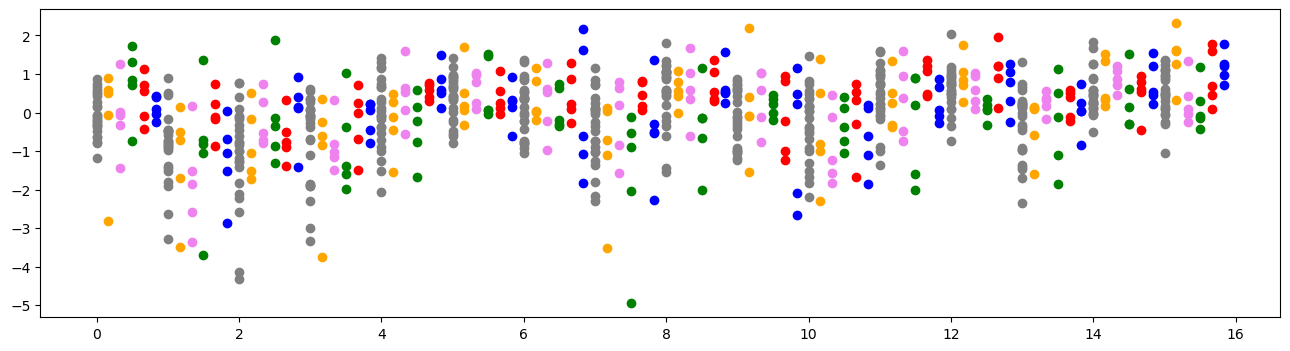

In [712]:
plt.figure(figsize = (16, 4))
plot_features_in_batches(features, 'scaled_entropy_mu')

In [713]:
# Mu power band entropy in the 0th and 2nd batch correlates with the outcome
for batch in unique_batches:
    dt = features[features['Batch'] == batch]
    corr = spearmanr(dt['scaled_entropy_mu'], dt['Event'])
    if corr[1] < p_sign_level:
        print(batch, corr[0])

0 0.25555697580986725
2 0.2838664091825615


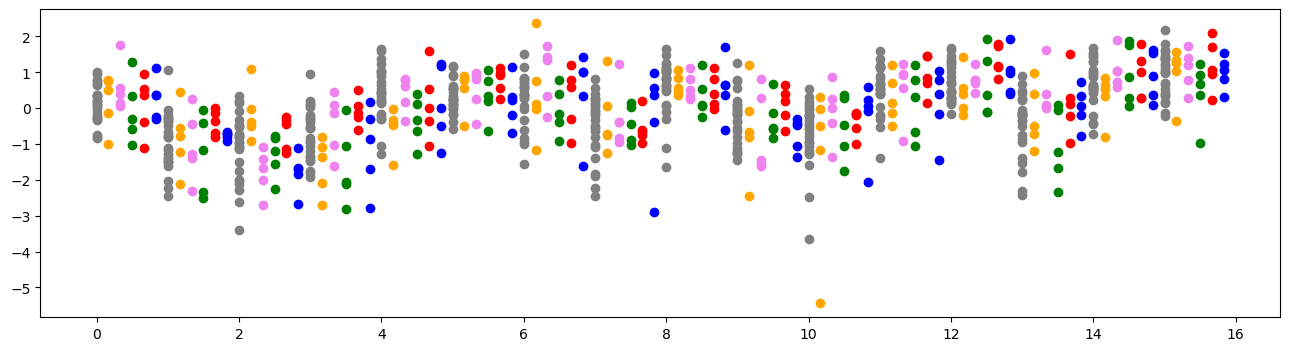

In [714]:
plt.figure(figsize = (16, 4))
plot_features_in_batches(features, 'scaled_entropy_beta')

In [715]:
# Beta power band entropy correlated on the 4th batch
for batch in unique_batches:
    dt = features[features['Batch'] == batch]
    corr = spearmanr(dt['scaled_entropy_beta'], dt['Event'])
    if corr[1] < p_sign_level:
        print(batch, corr[0])

4 -0.24989508913532837


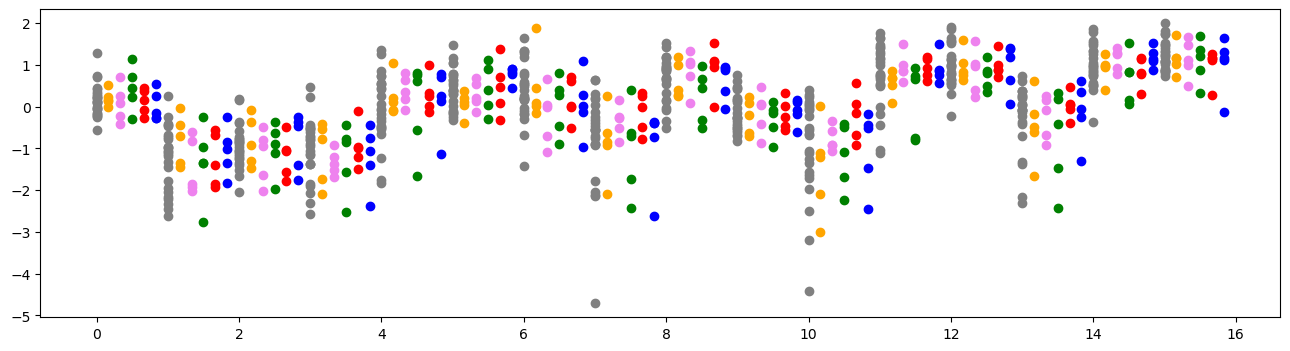

In [716]:
plt.figure(figsize = (16, 4))
plot_features_in_batches(features, 'scaled_entropy_gamma')

In [717]:
# Gamma power band entropy not correlated with outcome in any of the channels
for batch in unique_batches:
    dt = features[features['Batch'] == batch]
    corr = spearmanr(dt['scaled_entropy_gamma'], dt['Event'])
    if corr[1] < p_sign_level:
        print(batch, corr[0])

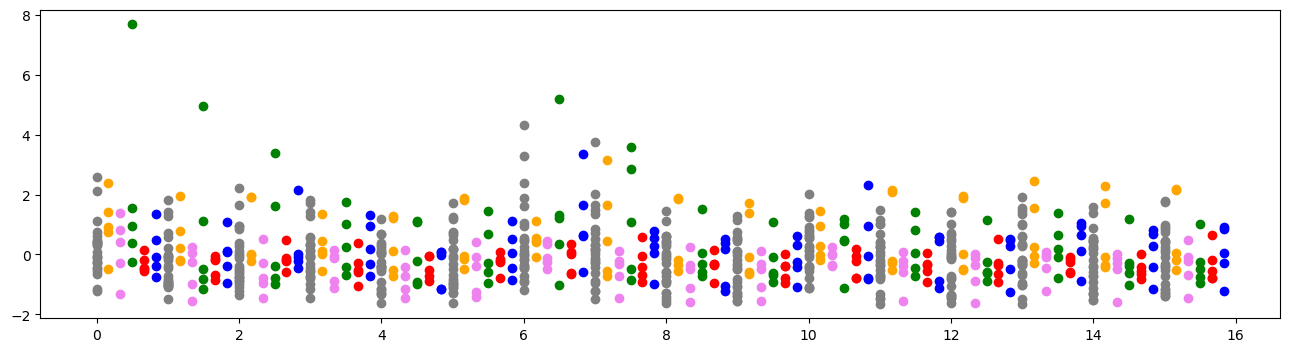

In [718]:
plt.figure(figsize = (16, 4))
plot_features_in_batches(features, 'sd_mu')

In [719]:
# Mu SD not correlated with outcome in any of the channels
for batch in unique_batches:
    dt = features[features['Batch'] == batch]
    corr = spearmanr(dt['sd_mu'], dt['Event'])
    if corr[1] < p_sign_level:
        print(batch, corr[0])

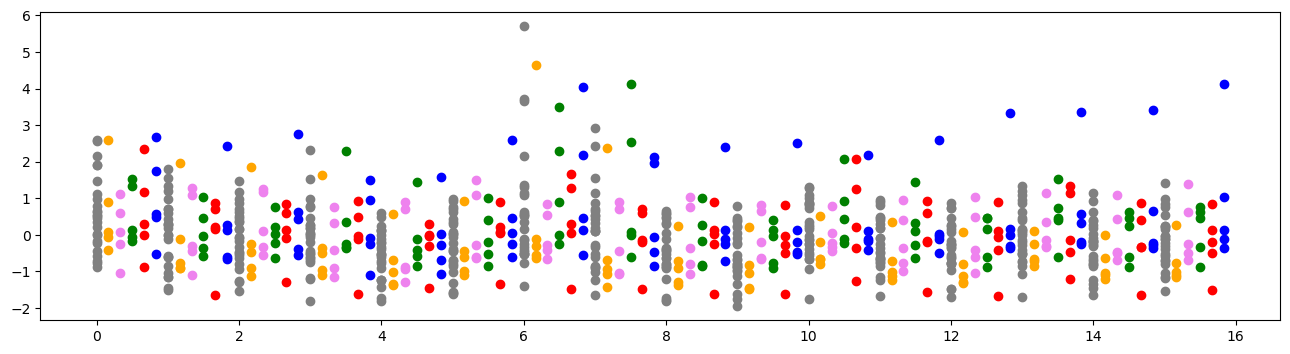

In [720]:
plt.figure(figsize = (16, 4))
plot_features_in_batches(features, 'sd_beta')

In [721]:
# Beta SD correlated on the 9th batch
for batch in unique_batches:
    dt = features[features['Batch'] == batch]
    corr = spearmanr(dt['sd_beta'], dt['Event'])
    if corr[1] < p_sign_level:
        print(batch, corr[0])

9 0.25401282489862936


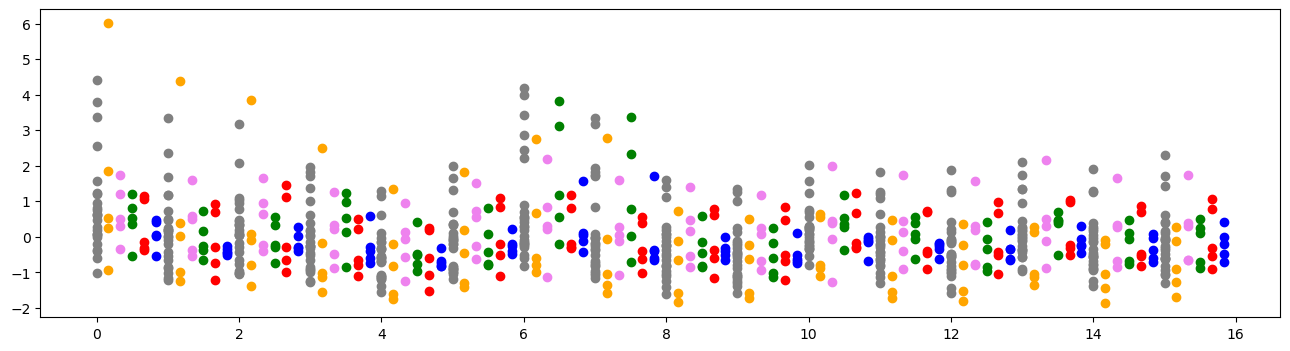

In [722]:
plt.figure(figsize = (16, 4))
plot_features_in_batches(features, 'sd_gamma')

In [723]:
# Gamma sd not correlated with the outcome
for batch in unique_batches:
    dt = features[features['Batch'] == batch]
    corr = spearmanr(dt['sd_gamma'], dt['Event'])
    if corr[1] < p_sign_level:
        print(batch, corr[0])

## Finalize the selected features

In [724]:
selected1 = features[features['Batch'] == 2][['EventID', 'Event', 'scaled_entropy_mu']]
selected2 = features[features['Batch'] == 0][['EventID', 'scaled_entropy_mu']]
selected3 = features[features['Batch'] == 15][['EventID', 'mu']]
selected4 = features[features['Batch'] == 4][['EventID', 'scaled_entropy_beta']]
selected5 = features[features['Batch'] == 9][['EventID', 'sd_beta']]

selected = pd.merge(selected1, selected2, on = 'EventID')
selected = pd.merge(selected, selected3, on = 'EventID')
selected = pd.merge(selected, selected4, on = 'EventID')
selected = pd.merge(selected, selected5, on = 'EventID')

In [725]:
selected

,EventID,Event,scaled_entropy_mu_x,scaled_entropy_mu_y,mu,scaled_entropy_beta,sd_beta
0,Event0,0.0,-0.830749,-0.631601,-0.023954,-0.225383,-0.863004
1,Event1,4.0,1.877677,1.302479,0.392905,0.116403,-0.905609
2,Event2,0.0,-1.189861,-0.641980,-0.303338,-1.060341,-0.801588
3,Event3,4.0,-0.140227,1.724137,0.235929,-1.284660,0.412823
4,Event4,0.0,-2.225743,-0.482725,0.627748,-1.287898,-1.607636
5,Event5,2.0,-0.158093,0.900477,2.366892,-0.019469,0.227088
6,Event6,0.0,-0.764046,-0.189607,1.483851,-0.300504,-0.242436
7,Event7,6.0,0.153913,0.093334,-0.281252,-1.248915,-0.527553
8,Event8,0.0,-0.159469,0.658793,0.489392,0.156738,-0.541615
9,Event9,4.0,-0.357899,0.855662,-0.219011,-0.627388,-0.024002


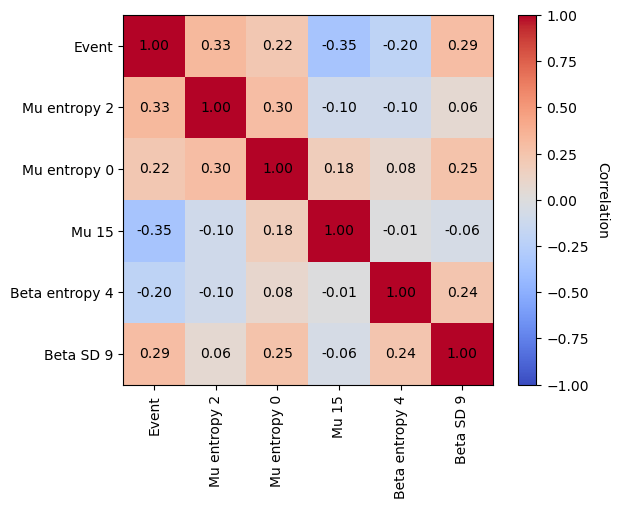

In [726]:
corr = np.corrcoef(selected.iloc[:, [1, 2, 3, 4, 5, 6]].T)

heatmap = plt.imshow(corr, cmap = 'coolwarm', vmax = 1, vmin = -1)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f'{corr[i, j]:.2f}', ha = 'center', va = 'center', color = 'black')

cbar = plt.colorbar(heatmap)
cbar.set_label('Correlation', rotation = 270, labelpad = 15)

feature_names = ['Event', 'Mu entropy 2', 'Mu entropy 0', 'Mu 15', 'Beta entropy 4', 'Beta SD 9']

plt.yticks(range(len(corr)), feature_names)
plt.xticks(range(len(corr)), feature_names, rotation = 90)

plt.show()

## Principal component analysis

In [727]:
pca = sklearn.decomposition.PCA(n_components = 2)
principal_components = pca.fit_transform(selected.iloc[:, [2, 3, 4, 5, 6]])

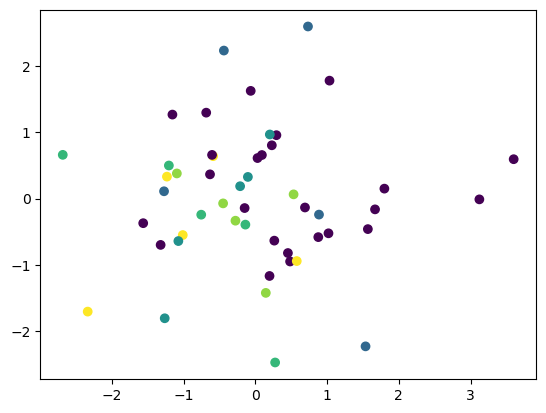

In [728]:
plt.scatter(principal_components[:, 0], principal_components[:, 1], c = selected['Event'])
plt.show()